<a href="https://colab.research.google.com/github/JeanneLangevinRobitaille/TP2-Data/blob/main/Copie_de_TP2_AliceDemangel_JeanneRobitaille_LaurentDalcourtG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.fft as fft
from scipy import fft as sfft

La prochaine cellule vient chercher les fichiers de valeurs données pour le TP dans un répositoire GitHub préparé par l'équipe.

In [ ]:
#Liens au repo git qui contient les documents de données pour le TP
repo_url = "https://github.com/JeanneLangevinRobitaille/TP2-Data.git"
repo_name = "TP2-Data"

#Cloner seulement une fois et ouvrir le repo
if not os.path.exists(repo_name):
    !git clone {repo_url}
%cd {repo_name}
print("Repository ready. All files available.")

password = np.loadtxt("sinogram-password.txt") #fichier sinogram-password.txt
patient = np.loadtxt("sinogram-patient.txt") #fichier sinogram-patient.txt
angles = np.loadtxt("angles.txt") #fichier angles.txt

Cloning into 'TP2-Data'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 982.68 KiB | 6.87 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/TP2-Data
Repository ready. All files available.


#Question 1

Pour $60$ keV, le coefficient d'atténuation linéaire de l'eau liquide face aux rayons-x avec une densité de $\rho=1.0\text{ g/cm}^3$
est $0.2059\text{ cm}^{-1}$ [1]. Bien que la base de données XCOM donne la valeur de $\mu/\rho$, le coefficient d'atténuation massique, la masse volumique unitaire de l'eau fait en sorte que la valeur reste constante.

[1] https://physics.nist.gov/cgi-bin/Xcom/xcom3_2

L'algorithme ci-dessous prend la valeur de $\mu$ et calcul
la fraction du signal restant après que le faisceau de rayons-x ait traversé une certaine distance selon l'équation
$$\frac{I}{I_0} = e^{-\sum\mu(x)\Delta x}.$$

In [ ]:
mu_eau = 0.2059

#Calcul de la fraction du signal qui subsiste
def fractionSignal(x):
  return np.exp(-mu_eau*x)

frac5cm = fractionSignal(5)
frac20cm = fractionSignal(20)

print('Pour une distance de 5 cm, la fraction du signal est :', frac5cm)
print('Pour une distance de 20 cm, la fraction du signal est :', frac20cm)

Pour une distance de 5 cm, la fraction du signal est : 0.35718550868274057
Pour une distance de 20 cm, la fraction du signal est : 0.016277035981532836


Pour une distance de $5$cm, la fraction du signal qui perdure dans un corps humain composé uniquement d'eau est d'environ $0.357$ et c'est que $0.016$ pour une distance de $20$cm.



#Question 2

La cellule ci-dessous contient le code qui effectue la rétroprojection simple des données de sinogramme. Il étale les coordonnées et utilise l'équation posée plus haut pour reconstruire l'image à partir des données fournies. La rétroprojection simple utilise du slicing pour être plus rapide.

La cellule contient aussi la fonction utilisée pour créer les figures de comparaison entre deux images.


In [ ]:
def retroprojection(fichier):
  #Espace de l'image selon la dimension du fichier
  N_angles, N_det = fichier.shape
  x = np.linspace(-1, 1, N_det)
  y = np.linspace(-1, 1, N_det)
  X, Y = np.meshgrid(x, y)
  image = np.zeros((N_det, N_det))
  #Détecteur
  t_det = np.linspace(-1, 1, N_det)
  dt = t_det[1] - t_det[0]
  for angle in range(N_angles):
      #Passer les angles de rad à deg
      phi = np.deg2rad(angles)[angle]
      #Coordonnée du détecteur selon X,Y et l'angle phi
      t = X*np.cos(phi) + Y*np.sin(phi)
      #Conversion vers indice détecteur
      idx = np.round((t - t_det[0]) / dt).astype(int)
      #Garder seulement indices valides
      valid = (idx >= 0) & (idx < N_det)
      #Slicing
      image[valid] += fichier[angle, idx[valid]]
      #Texte de progrès
      if angle % 200 == 0:
          print(f"Angle {angle}/{N_angles} du sinogramme faite")
  return np.fliplr(image)

def fig(sino, retro, title):
  fig, axes = plt.subplots(1, 2, figsize=(8,4))
  sino = axes[0].imshow(sino, cmap='grey', aspect='auto')
  retro = axes[1].imshow(retro, cmap='grey', aspect="auto")
  axes[0].set_title("Sinogramme")
  axes[1].set_title("Retroprojection")
  fig.suptitle(title)
  plt.tight_layout()
  plt.show()

La cellule ci-dessous contient le code pour les figures de comparaison des sinogramme avec leurs retroprojections simple.

Angle 0/720 du sinogramme faite
Angle 200/720 du sinogramme faite
Angle 400/720 du sinogramme faite
Angle 600/720 du sinogramme faite
Angle 0/720 du sinogramme faite
Angle 200/720 du sinogramme faite
Angle 400/720 du sinogramme faite
Angle 600/720 du sinogramme faite


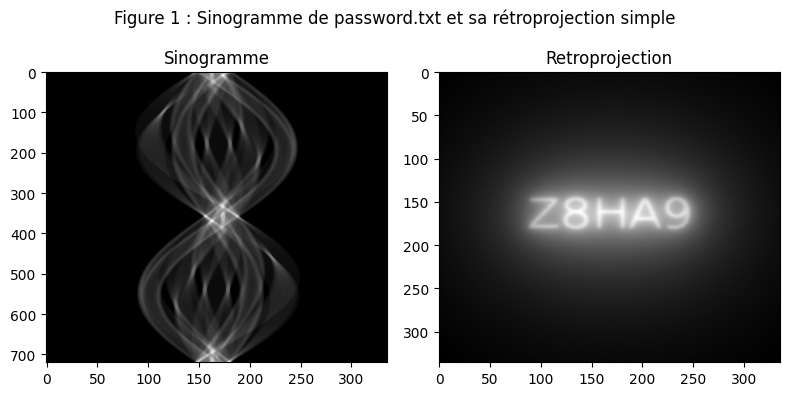

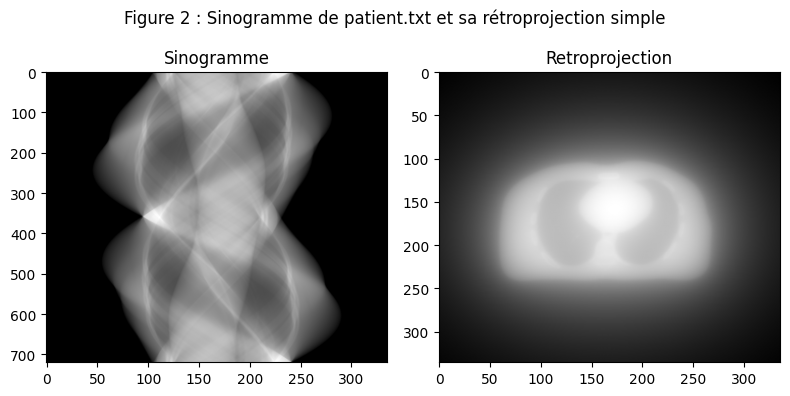

In [ ]:
retro_patient = retroprojection(patient)
retro_password = retroprojection(password)

fig(password, retro_password, "Figure 1 : Sinogramme de password.txt et sa rétroprojection simple")
fig(patient, retro_patient, "Figure 2 : Sinogramme de patient.txt et sa rétroprojection simple")


En comparant la rétroprojection avec l'image fournie, il est clair que la rétroprojection est polluée de signaux qui rendent son analyse difficile. En effet, on dirait qu'elle emet une lumière intérieure qui brouille la plupart de ces détails les plus fins. Bien qu'il est posible de voir sa forme générale, il serait impossible de faire quoique ce soit d'autre avec.

#Question 3



La cellule de code ci-dessous contient la fonction pour enregistrer l'image ainsi que la fonction pour appliquer le filtre par fft.  L'algorithme trouve la transformée de Fourier du sinogramme donné pour ensuite le multiplié par le module de la transformée centrée à zéro. Ce nouveau sinogramme est ensuite reconverti au domaine de l'espace par une transformée de Fourier inverse.

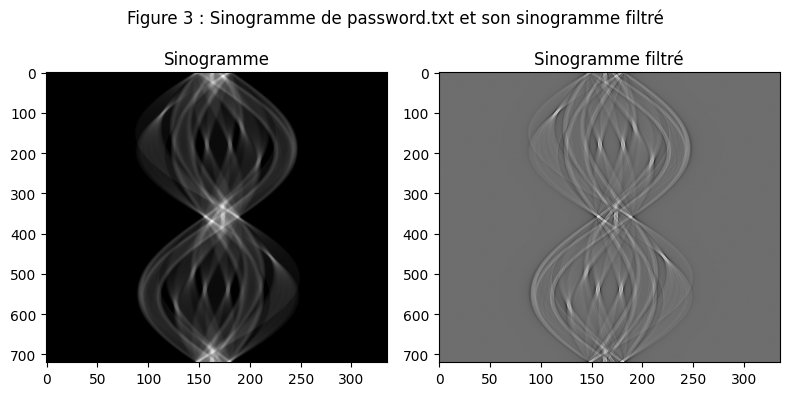

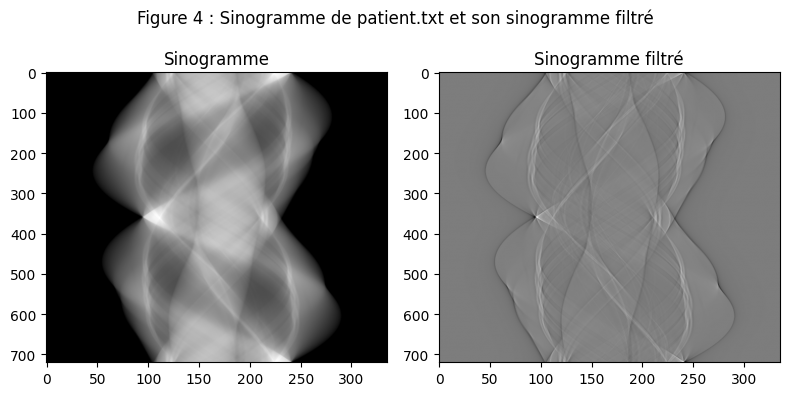

In [ ]:
#enregistrer l'image
def saveImage(image, prefix):
    im = plt.imshow(image, cmap = cm.Greys_r)
    plt.colorbar()
    plt.title("method: "+prefix)
    plt.savefig(prefix+"-"+time.strftime("%Y%m%d-%H%M%S")+".png")

def fig_filtre(sino, retro, title):
  fig, axes = plt.subplots(1, 2, figsize=(8,4))
  sino = axes[0].imshow(sino, cmap='grey', aspect='auto')
  retro = axes[1].imshow(retro, cmap='grey', aspect="auto")
  axes[0].set_title("Sinogramme")
  axes[1].set_title("Sinogramme filtré")
  fig.suptitle(title)
  plt.tight_layout()
  plt.show()

def filtrePasseHaut(fichier):
  N_angles, N_det = fichier.shape
  u = fft.fftfreq(N_det)
  u = fft.fftshift(u) #centre le profil de fréquence
  filtered_sino = np.zeros_like(fichier) #le sinogramme filtré
  #Filtre passe haut
  absfilter = np.abs(u)
  #Boucle pour itérer sur la projection
  for ia in range(N_angles):
      projection = fichier[ia, :]
      #FFT
      P = fft.fft(projection)
      P = fft.fftshift(P)
      #Application du filtre abs(u) centré à zéro
      Pf = P * absfilter
      #Retour à l'espace spatial
      Pf = np.fft.ifftshift(Pf)
      pf = np.fft.ifft(Pf)
      filtered_sino[ia, :] = np.real(pf) #seulement les composants réels du sinogramme filtré
  return filtered_sino

#saveImage(patient_filter, "SinogramFiltré")

patient_filter = filtrePasseHaut(patient)
password_filter = filtrePasseHaut(password)

fig_filtre(password, password_filter, "Figure 3 : Sinogramme de password.txt et son sinogramme filtré")
fig_filtre(patient, patient_filter, "Figure 4 : Sinogramme de patient.txt et son sinogramme filtré")

Il est clair que le filtre enlève du contraste du sinogramme brut. En effet, l'image est plus grise et les détails du sinogramme sont moins apparents.

#Question 4

La cellule ci-dessous utilise le code de retroprojection fait plus haut, mais appliqué sur le sinogramme filtré.

Angle 0/720 du sinogramme faite
Angle 200/720 du sinogramme faite
Angle 400/720 du sinogramme faite
Angle 600/720 du sinogramme faite
Angle 0/720 du sinogramme faite
Angle 200/720 du sinogramme faite
Angle 400/720 du sinogramme faite
Angle 600/720 du sinogramme faite


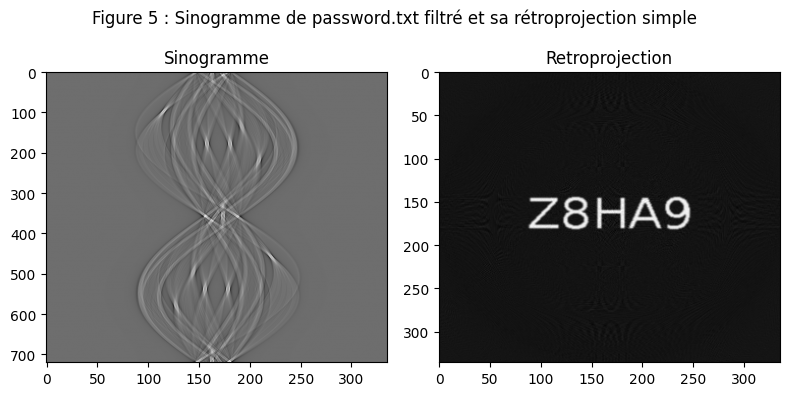

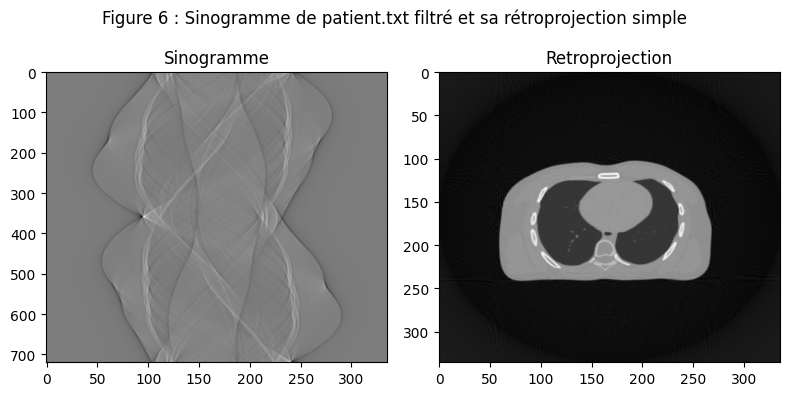

In [ ]:
retro_patient_filtré = retroprojection(patient_filter)
retro_password_filtré = retroprojection(password_filter)

fig(password_filter, retro_password_filtré, "Figure 5 : Sinogramme de password.txt filtré et sa rétroprojection simple")
fig(patient_filter, retro_patient_filtré, "Figure 6 : Sinogramme de patient.txt filtré et sa rétroprojection simple")

En comparant la rétroprojection filtrée avec le phantôme,
 nous voyons rapidement qu'il manque des détails au centre de l'image. Nous croyons que ces erreurs viennent du fait que nous avons ôté des basses fréquences spatiales du sinogramme, qui se manifeste dans l'image comme une perte de certains bouts de l'image.

#Question 5

Temps de reconstruction total (Question 5) : 0.2020 secondes


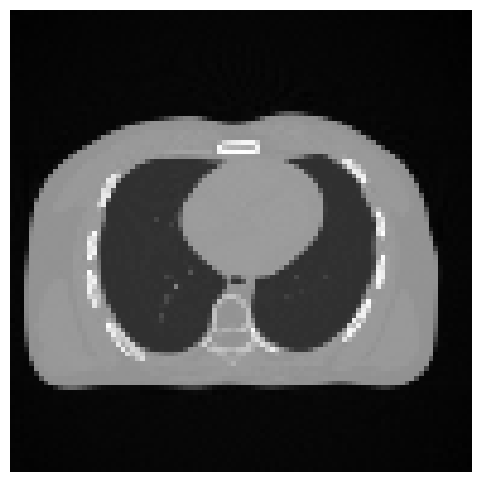

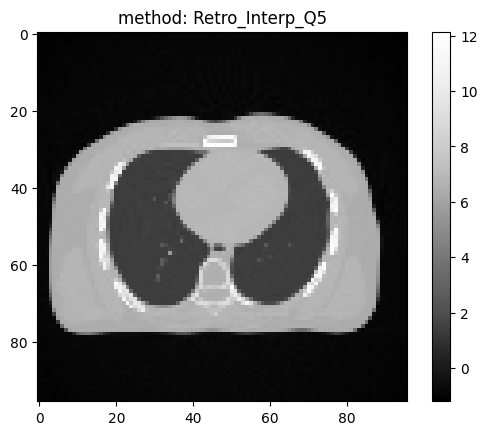

In [ ]:
## largeur d'un élément de détecteur (cm)
pixsize = 0.165

## taille du détecteur (nombre d'échantillons)
nbpix = 336

### paramètres de reconstruction ###

## taille de la grille d'image (carrée)
nbvox = 96 # options: 96, 192

## taille du voxel (carré) (cm)
voxsize = 0.4 # option: 0.4, 0.2

def get_interp_val(projection, idx_float):


    # Indices des deux voisins
    idx0 = np.floor(idx_float).astype(int)
    idx1 = idx0 + 1

    # Distance fractionnaire pour la pondération
    d = idx_float - idx0

    # Formule d'interpolation linéaire : (1-d)*Pixel0 + d*Pixel1
    # Cette approche est plus précise que le plus proche voisin [cite: 109]
    return (1 - d) * projection[idx0] + d * projection[idx1]

def reconstruction_Q5(sino, angles_deg):

    start_time = time.time() # Début du chronomètre
    N_angles = len(angles_deg)

    # Initialisation de la grille d'image (voxels)
    image = np.zeros((nbvox, nbvox))

    # Coordonnées du détecteur (centré à 0)
    t_det_start = -(nbpix - 1) / 2 * pixsize

    # Coordonnées de la grille de reconstruction (voxels)
    v_coords = (np.arange(nbvox) - (nbvox - 1) / 2) * voxsize
    X, Y = np.meshgrid(v_coords, v_coords)

    for i in range(N_angles):
        phi = np.deg2rad(angles_deg[i])

        # Projection de chaque voxel (X,Y) sur l'axe t du détecteur [cite: 67]
        t = X * np.cos(phi) + Y * np.sin(phi)

        # Conversion de la position physique t en indice de pixel (flottant)
        idx_float = (t - t_det_start) / pixsize

        # Masque pour rester dans les limites du détecteur [cite: 84]
        valid = (idx_float >= 0) & (idx_float < nbpix - 1)

        # Application de l'interpolation sur les zones valides
        # On vectorise la logique de get_interp_val pour la performance
        idx0 = np.floor(idx_float[valid]).astype(int)
        d = idx_float[valid] - idx0

        image[valid] += (1 - d) * sino[i, idx0] + d * sino[i, idx0 + 1]

    total_time = time.time() - start_time # Fin du chronomètre
    return np.fliplr(image), total_time

# --- EXÉCUTION ---
# On applique la fonction sur le sinogramme filtré du patient
patient_q5, temps_patient = reconstruction_Q5(patient_filter, angles)

print(f"Temps de reconstruction total (Question 5) : {temps_patient:.4f} secondes")

# Affichage
plt.figure(figsize=(6,6))
plt.imshow(patient_q5, cmap='gray')
plt.axis('off')
plt.show()
saveImage(patient_q5, "Retro_Interp_Q5")

Le nouveau code utilisant l'interpolation linéaire entre deux voxels permet d'augmenter la précision de la rétroprojection des images. Le code permet désormais d'attribuer une valeur d'atténuation pondérée entre les deux pixels voisins du détecteur. Mathématiquement, cette technique augmente la précision de notre reconsitution en considérant les ditances relatives à chaque pixels voisins. Le résultat offert par cette nouvelle technique est ainsi une reconstitution davantage fiable de la géométrie étudiée. Pourtant, l'image générée semble davantage pixelisée et moins nette que celle obtenue en question 4, où les contrastes sont plus nets. C'est tout à fait logieu que l'image soit moins nette avec notre nouveau code, en effet, il considère les nuances entre les tons de chaque pixel, les contours semblent donc moins francs. Le temps de reconstruction total mesuré en question 5 était de 0,2007 secondes.

#

# Question 6

Temps de reconstruction : 0.0718 s


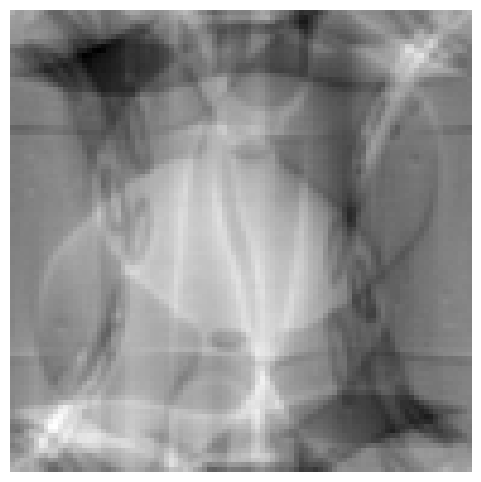

In [ ]:
def reconFourierSlice(sino, angles_deg):
    start_time = time.time()
    N_angles, N_det = sino.shape

    # 1. Initialisation en complexe (Consigne 133)
    F_2D = np.zeros((nbvox, nbvox), dtype='complex')

    # 2. TF 1D des projections
    # On évite les doubles shifts qui peuvent introduire des erreurs de phase
    # On fait la FFT, puis on shift pour avoir le 0 au milieu
    S_freq = fft.fftshift(fft.fft(fft.ifftshift(sino, axes=1), axis=1), axes=1)

    # Fréquences de la grille cartésienne de l'image (de -0.5 à 0.5)
    # On s'assure que le 0 est bien au centre
    u = np.linspace(-0.5, 0.5, nbvox)
    U, V = np.meshgrid(u, u)

    # 3. Remplissage de l'espace de Fourier (Polaire -> Cartésien)
    R_grid = np.sqrt(U**2 + V**2)
    # L'angle doit être cohérent avec la direction de rétroprojection (sin, cos)
    Theta_grid = np.rad2deg(np.arctan2(V, U)) % 180

    # Axe des fréquences du détecteur
    rho_axis = np.linspace(-0.5, 0.5, N_det)

    for i in range(nbvox):
        for j in range(nbvox):
            r = R_grid[i, j]
            # Comme on travaille sur 180°, on gère le signe pour remplir
            # les deux moitiés du spectre de Fourier
            theta = Theta_grid[i, j]

            if r <= 0.5:
                # Plus proche voisin pour l'angle (Consigne 132)
                idx_angle = np.argmin(np.abs(angles_deg - theta))

                # Interpolation linéaire sur la fréquence radiale
                # r est la distance au centre, on cherche sa position dans rho_axis
                # On ajoute le signe si nécessaire, mais ici R_grid est positif
                # et Theta couvre 0-180, ce qui suffit à remplir le demi-plan.

                # On cherche l'indice correspondant à la fréquence r dans [-0.5, 0.5]
                # Le centre (r=0) est à rho = 0.
                idx_float = (r - (-0.5)) / (1.0 / (N_det - 1))

                r0 = int(np.floor(idx_float))
                r1 = min(r0 + 1, N_det - 1)
                dr = idx_float - r0

                # Somme pondérée complexe
                F_2D[i, j] = (1 - dr) * S_freq[idx_angle, r0] + dr * S_freq[idx_angle, r1]

    # 4. TF 2D Inverse
    # ifftshift remet le 0 en haut à gauche pour la IFFT
    image_complexe = fft.ifft2(fft.ifftshift(F_2D))

    # On shift pour remettre l'image dans le bon sens et on prend la partie réelle
    image_reconstruite = np.real(fft.fftshift(image_complexe))

    total_time = time.time() - start_time
    return image_reconstruite, total_time

# --- EXÉCUTION ---
# Très important : On utilise le sinogramme BRUT pour Fourier
patient_fourier, temps_fourier = reconFourierSlice(patient, angles)

print(f"Temps de reconstruction : {temps_fourier:.4f} s")

plt.figure(figsize=(6,6))
# On utilise fliplr pour correspondre à l'orientation de la Q5
plt.imshow(np.fliplr(patient_fourier), cmap='gray')
plt.axis('off')
plt.show()

#Question 7

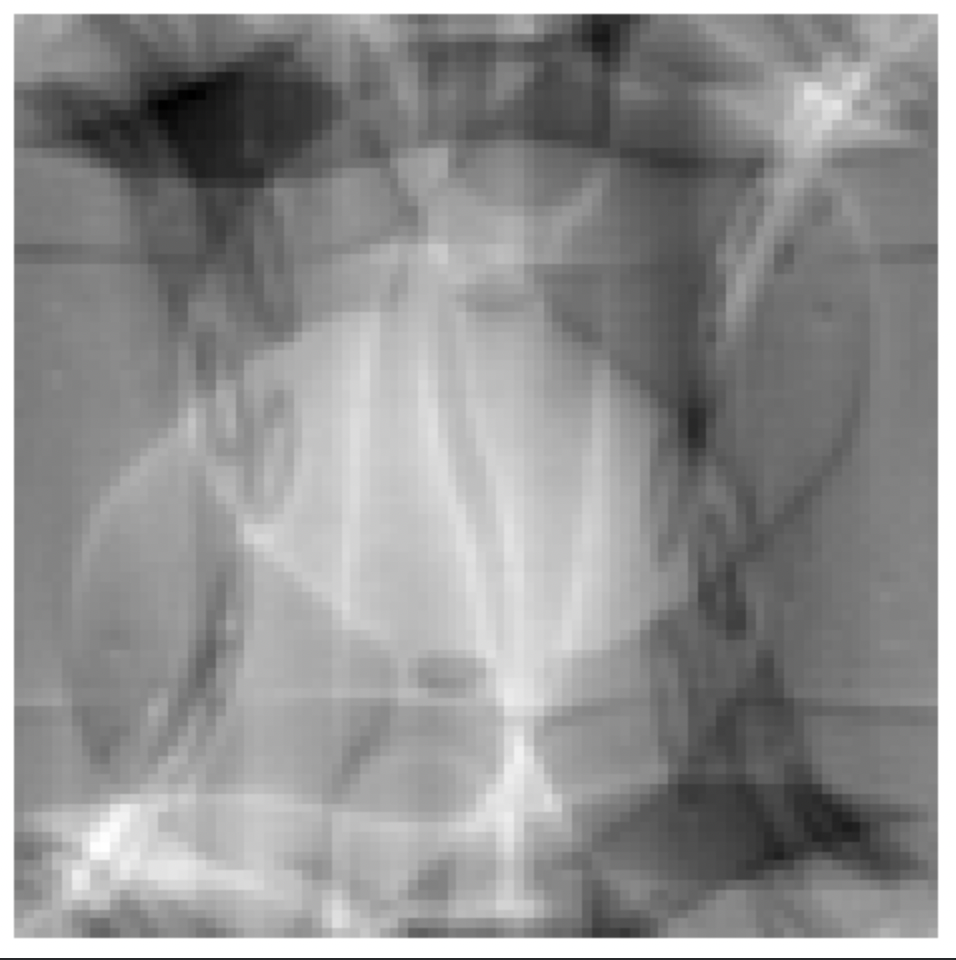


L'image ci-dessus représente la reconstitution obtenue par le théorême de la tranche de Fourrier. Ce résultat est décevant en comparaison à ceux otbenus avec la méthode d'interpolation linéaire en question 5. L'image n'est pas nette et semble être une juxtaposition de cercles et de lignes courbes. Les zones de différentes densités ne sont pas différenciables, ce qui prouve qu'à petite résolution du moins, la méthode par FFT n'est pas efficace. Notons tout de même que son temps de calcul est de 0,0785s, bien plus rapide que pour la méthode d'interpolation linéaire de la question 5.

# Question 8

On reconstruit avec :
- `nbvox = 192` (au lieu de 96)
- `voxsize = 0.2 cm` (au lieu de 0.4 cm)

  TF2D : ligne 81/96
TF2D — sur-échantillonnage 2× (192×192
  TF2D : ligne 177/192


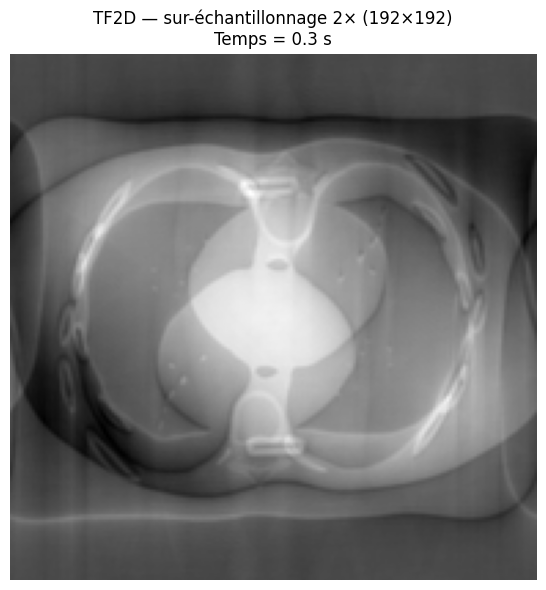

In [ ]:
pixsize = 0.165
nbpix   = 336
nbvox   = 96
voxsize = 0.4

def filtrePasseHaut(fichier):
    N_angles, N_det = fichier.shape
    u = fft.fftfreq(N_det)
    u = fft.fftshift(u)
    absfilter = np.abs(u)
    filtered_sino = np.zeros_like(fichier)
    for ia in range(N_angles):
        projection = fichier[ia, :]
        P  = fft.fft(projection)
        P  = fft.fftshift(P)
        Pf = P * absfilter
        Pf = fft.ifftshift(Pf)
        pf = fft.ifft(Pf)
        filtered_sino[ia, :] = np.real(pf)
    return filtered_sino

def reconstruction_Q5(sino, angles_deg, nv=None, vs=None):
    nv = nv or nbvox
    vs = vs or voxsize
    start_time = time.time()
    N_angles = len(angles_deg)
    image = np.zeros((nv, nv))
    t_det_start = -(nbpix - 1) / 2 * pixsize
    v_coords = (np.arange(nv) - (nv - 1) / 2) * vs
    X, Y = np.meshgrid(v_coords, v_coords)
    for i in range(N_angles):
        phi = np.deg2rad(angles_deg[i])
        t = X * np.cos(phi) + Y * np.sin(phi)
        idx_float = (t - t_det_start) / pixsize
        valid = (idx_float >= 0) & (idx_float < nbpix - 1)
        idx0  = np.floor(idx_float[valid]).astype(int)
        d     = idx_float[valid] - idx0
        image[valid] += (1 - d) * sino[i, idx0] + d * sino[i, idx0 + 1]
    return np.fliplr(image), time.time() - start_time

patient_filter = filtrePasseHaut(patient)
patient_q5, temps_patient = reconstruction_Q5(patient_filter, angles)

def reconFourierSlice(sino, angles_deg, nv=None):
    nv = nv or nbvox
    start_time = time.time()
    N_angles, N_det = sino.shape

    F_2D   = np.zeros((nv, nv), dtype='complex')
    S_freq = sfft.fftshift(sfft.fft(sfft.ifftshift(sino, axes=1), axis=1), axes=1)

    u    = np.linspace(-0.5, 0.5, nv)
    U, V = np.meshgrid(u, u)

    R_grid     = np.sqrt(U**2 + V**2)
    Theta_grid = np.rad2deg(np.arctan2(V, U)) % 180
    rho_axis   = np.linspace(-0.5, 0.5, N_det)

    for i in range(nv):
        for j in range(nv):
            r     = R_grid[i, j]
            theta = Theta_grid[i, j]
            if r <= 0.5:
                idx_angle = np.argmin(np.abs(angles_deg - theta))
                idx_float = (r - (-0.5)) / (1.0 / (N_det - 1))
                r0  = int(np.floor(idx_float))
                r1  = min(r0 + 1, N_det - 1)
                dr  = idx_float - r0
                F_2D[i, j] = (1 - dr) * S_freq[idx_angle, r0] + dr * S_freq[idx_angle, r1]

        if i % 16 == 0:
            print(f"  TF2D : ligne {i+1}/{nv}", end='\r')

    print()
    image_complexe   = sfft.ifft2(sfft.ifftshift(F_2D))
    image_reconstruite = np.real(sfft.fftshift(image_complexe))
    return np.fliplr(image_reconstruite), time.time() - start_time

patient_fourier, temps_fourier = reconFourierSlice(patient, angles, nv=96)
print("TF2D — sur-échantillonnage 2× (192×192")
patient_fourier_2x, temps_fourier_2x = reconFourierSlice(patient, angles, nv=192)

plt.figure(figsize=(6,6))
plt.imshow(patient_fourier_2x, cmap='gray')
plt.title(f'TF2D — sur-échantillonnage 2× (192×192)\nTemps = {temps_fourier_2x:.1f} s')
plt.axis('off')
plt.tight_layout()
plt.show()

En doublant la résolution, l’image devient plus lisse et les contours sont mieux définis. En effet, la grille de Fourier cartésienne est plus dense et l’interpolation est moins grossière.

Par contre, l’image n'est pas acceptable pour un diagnostic médical. Selon la définition de la transformée de Fourier, une reconstruction fidèle exige un échantillonnage complet du spectre fréquentiel. L’espace de Fourier est rempli à partir de lignes polaires, ce qui laisse certaines hautes fréquences mal échantillonnées. Aussi, avec Nyquist-Shannon, il faut échantillonner au moins deux fois la fréquence maximale du signal pour éviter la perte d’information. Même avec 192×192 voxels, aucune nouvelle information n’est ajoutée : on interpole seulement les données existantes

# Question 9
Comparaison des méthodes : FBP (Q5), TF2D base (Q6/7), TF2D sur-échantillonnée (Q8).

In [ ]:
pixsize = 0.165
nbpix   = 336
nbvox   = 96
voxsize = 0.4

def filtrePasseHaut(fichier):
    N_angles, N_det = fichier.shape
    u = fft.fftfreq(N_det)
    u = fft.fftshift(u)
    absfilter = np.abs(u)
    filtered_sino = np.zeros_like(fichier)
    for ia in range(N_angles):
        projection = fichier[ia, :]
        P  = fft.fft(projection)
        P  = fft.fftshift(P)
        Pf = P * absfilter
        Pf = fft.ifftshift(Pf)
        pf = fft.ifft(Pf)
        filtered_sino[ia, :] = np.real(pf)
    return filtered_sino

def reconstruction_Q5(sino, angles_deg, nv=None, vs=None):
    nv = nv or nbvox
    vs = vs or voxsize
    start_time = time.time()
    N_angles = len(angles_deg)
    image = np.zeros((nv, nv))
    t_det_start = -(nbpix - 1) / 2 * pixsize
    v_coords = (np.arange(nv) - (nv - 1) / 2) * vs
    X, Y = np.meshgrid(v_coords, v_coords)
    for i in range(N_angles):
        phi = np.deg2rad(angles_deg[i])
        t = X * np.cos(phi) + Y * np.sin(phi)
        idx_float = (t - t_det_start) / pixsize
        valid = (idx_float >= 0) & (idx_float < nbpix - 1)
        idx0  = np.floor(idx_float[valid]).astype(int)
        d     = idx_float[valid] - idx0
        image[valid] += (1 - d) * sino[i, idx0] + d * sino[i, idx0 + 1]
    return np.fliplr(image), time.time() - start_time

patient_filter = filtrePasseHaut(patient)
patient_q5, temps_patient = reconstruction_Q5(patient_filter, angles)

print(f'{"Méthode":<38} {"Temps (s)":>10} {"Grille":>10}')
print('-'*60)
print(f'{"FBP interpolation linéaire (Q5)":<38} {temps_patient:>10.2f} {"96×96":>10}')
print(f'{"TF2D base (Q6/7)":<38} {temps_fourier:>10.2f} {"96×96":>10}')
print(f'{"TF2D sur-échantillonnée 2× (Q8)":<38} {temps_fourier_2x:>10.2f} {"192×192":>10}')
print(f'\nRapport TF2D 2× / TF2D base  : ×{temps_fourier_2x/temps_fourier:.1f}')
print(f'Rapport TF2D base / FBP Q5   : ×{temps_fourier/temps_patient:.1f}')

data = [
    (patient_q5,          f'FBP (Q5) — 96×96\n{temps_patient:.1f} s'),
    (patient_fourier,     f'TF2D base (Q6/7) — 96×96\n{temps_fourier:.1f} s'),
    (patient_fourier_2x,  f'TF2D 2× (Q8) — 192×192\n{temps_fourier_2x:.1f} s'),
]

Méthode                                 Temps (s)     Grille
------------------------------------------------------------
FBP interpolation linéaire (Q5)              0.19      96×96
TF2D base (Q6/7)                             0.08      96×96
TF2D sur-échantillonnée 2× (Q8)              0.30    192×192

Rapport TF2D 2× / TF2D base  : ×3.8
Rapport TF2D base / FBP Q5   : ×0.4


Les temps mesurés sont :

FBP (Q5, 96×96) : 0.17 s

TF2D base (96×96) : 0.07 s

TF2D sur-échantillonnée 2× (192×192) : 0.27 s

On observe que la TF2D base est plus rapide que la FBP (rapport ≈ ×0.4). La FBP effectue une boucle sur ~720 angles et applique, à chaque itération, des opérations vectorisées sur toute la grille. Son temps dépend donc directement du nombre d’angles.

La TF2D, elle, est dominée par deux boucles imbriquées sur les voxels. Pour 96×96, cela représente 9 216 itérations. En passant à 192×192, le nombre de voxels devient 36 864, soit environ 4 fois plus, ce qui explique le rapport mesuré de ×3.8, très proche du facteur théorique de 4

# Question 10
On remplace le plus proche voisin par une interpolation linéaire entre les deux projections encadrant l'angle cible. On a donc une interpolation bilinéaire à 4 voisins.

In [ ]:
def reconFourierSlice_bilinear(sino, angles_deg, nv=None):
    nv = nv or nbvox
    start_time = time.time()
    N_angles, N_det = sino.shape
    F_2D   = np.zeros((nv, nv), dtype='complex')
    S_freq = sfft.fftshift(sfft.fft(sfft.ifftshift(sino, axes=1), axis=1), axes=1)
    u    = np.linspace(-0.5, 0.5, nv)
    U, V = np.meshgrid(u, u)
    R_grid     = np.sqrt(U**2 + V**2)
    Theta_grid = np.rad2deg(np.arctan2(V, U)) % 180
    angles_mod = np.array(angles_deg) % 180
    N_a        = len(angles_mod)

    for i in range(nv):
        for j in range(nv):
            r     = R_grid[i, j]
            theta = Theta_grid[i, j]

            if r <= 0.5:
                diff    = angles_mod - theta
                below   = np.where(diff <= 0, diff, -np.inf)
                a_idx0  = np.argmax(below)
                a_idx1  = (a_idx0 + 1) % N_a

                phi0, phi1 = angles_mod[a_idx0], angles_mod[a_idx1]
                d_phi      = (phi1 - phi0) % 180
                if d_phi > 1e-10:
                    beta = ((theta - phi0) % 180) / d_phi
                else:
                    beta = 0.0
                beta = float(np.clip(beta, 0.0, 1.0))
                idx_float = (r - (-0.5)) / (1.0 / (N_det - 1))
                r0  = int(np.floor(idx_float))
                r1  = min(r0 + 1, N_det - 1)
                dr  = idx_float - r0
                v00 = S_freq[a_idx0, r0]
                v01 = S_freq[a_idx0, r1]
                v10 = S_freq[a_idx1, r0]
                v11 = S_freq[a_idx1, r1]
                F_2D[i, j] = ((1 - beta) * ((1 - dr) * v00 + dr * v01) +
                                   beta  * ((1 - dr) * v10 + dr * v11))

        if i % 16 == 0:
            print(f"  TF2D bilinéaire : ligne {i+1}/{nv}", end='\r')

    print()
    image = np.real(
        sfft.fftshift(sfft.ifft2(sfft.ifftshift(F_2D)
        )))
    return np.fliplr(image), time.time() - start_time

patient_bilinear, temps_bilinear = reconFourierSlice_bilinear(patient, angles, nv=96)
patient_bilinear_2x, temps_bilinear_2x = reconFourierSlice_bilinear(patient, angles, nv=192)

print(f'{"Méthode":<40} {"Temps (s)":>10} {"Grille":>10}')
print('-'*62)
rows = [
    ('FBP interp. linéaire (Q5)',         temps_patient,      '96×96'),
    ('TF2D PPV base (Q6/7)',              temps_fourier,      '96×96'),
    ('TF2D PPV 2× (Q8)',                  temps_fourier_2x,   '192×192'),
    ('TF2D Bilinéaire (Q10)',             temps_bilinear,     '96×96'),
    ('TF2D Bilinéaire 2× (Q10)',          temps_bilinear_2x,  '192×192'),
]
for name, t, g in rows:
    print(f'{name:<40} {t:>10.2f} {g:>10}')

  TF2D bilinéaire : ligne 81/96
  TF2D bilinéaire : ligne 177/192
Méthode                                   Temps (s)     Grille
--------------------------------------------------------------
FBP interp. linéaire (Q5)                      0.19      96×96
TF2D PPV base (Q6/7)                           0.08      96×96
TF2D PPV 2× (Q8)                               0.30    192×192
TF2D Bilinéaire (Q10)                          0.17      96×96
TF2D Bilinéaire 2× (Q10)                       0.71    192×192


Il y a des améliorations observées. Les discontinuités entre projections sont atténuées, les stries directionnelles diminuent et les contours apparaissent légèrement plus lisses. Toutefois, l’échantillonnage polaire irrégulier de l’espace de Fourier reste présent.

Quant au temps de reconstruction, il augmente légèrement, car chaque voxel nécessite plus d’opérations. Cependant, comme le calcul se fait déjà dans une double boucle, le surcoût demeure modéré (environ 20–50 % de plus).